In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict 
import pandas as pd

%matplotlib notebook
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
class Waligorski():
    def __init__(self, t_r,d_step, E_ion, m_ion, eloss):
        atnGa=31;
        atnN = 7;
        mGa=69.723;
        mN=14.0067;
        psSgcm3 = 6.15; # Density of GaN


        #nS = psS/((mGa+mN)/2*1.6605402e-27); 
        rhoe = psSgcm3*(atnGa+atnN)/(mGa+mN)

        #rhoe = 2.79

        c = 299792458.0
        me=9.10939e-31
            # [ kg ]   Electron mass

        alpha1=1.667;           # 1.667 for v_ion>0.03
        alpha2=1.079;           # 1.079 for v_ion<0.03

        k = 6.0e-6;   # 6.0e-6 g/cm**2 keV**(-alpha)     

        t = t_r*1e2 * rhoe  #1e2
            #radius in the Waligorski Units (g/cm2)
        m_ion = m_ion*1.6605402e-27;
            # Ion mass in kg  

        E_J_ion = E_ion*1e3*1.602177e-19
            # Ion energy in J
        v_ion=np.sqrt(2*E_J_ion/m_ion);
            # Ion velocity in [m/s]
        v_ion=v_ion/c
            # Ion velocity / c
        if v_ion<0.03:
            alpha=alpha2
        else:
            alpha=alpha1

        Emin= (5.9993+14.5341)/2*1e-3;      #For GaN in KeV
        Emax=2*me*c**2*v_ion**2/(1-v_ion**2)/1.602177e-16  # Maximum transferred energy [ keV ]

        RmaxS=k*Emax**alpha  
           #[g/cm**2] 

        RminS=k*Emin**1.079 
           #[g/cm**2]
            
               # Correction parameters from Waligorski (1986)
        if v_ion>0.03:
            Awal=19.0*v_ion**(1.0/3.0)
        else:
            Awal=8 * v_ion**(1.0/3.0)

        Bwal=0.1e-7;              # [cm], 0.1 nm
        Cwal=1.5e-7+v_ion*5.0e-7;  # [cm] 1.5 nm + 5 nm * beta
        #print(Awal, Bwal, Cwal, sep=' - ')
          
        self.t_r = t_r
        self.t = t
        self.E = E_ion
        self.v_ion = v_ion
        self.eloss = eloss
        self.RmaxS = RmaxS
        self.Rmins = RminS
        self.Emin = Emin
        self.k = k
        self.rhoe = rhoe
        self.d_step = d_step
        self.alpha = alpha
        self.Awal = Awal
        self.Bwal = Bwal
        self.Cwal = Cwal
        
        
        print('\n %.2e MeV'%(E_ion*1e-3))
        print('mass: %f'%m_ion)
        print('beta: %f'%v_ion)
        print('Rmax: %e'%RmaxS)
        print('Rmin: %e'%RminS)
        print('Emin: %f'%Emin)
        print('k: %f'%k)
        print('e density: %0.2f g/cm^3'%rhoe)
        print('e loss: %0.2f keV/nm'%eloss)
        print('d step: %e nm'%(d_step*1e9))
    
    def compute(self):
        t_r = self.t_r
        t = self.t
        E = self.E
        v_ion = self.v_ion
        eloss = self.eloss
        RmaxS = self.RmaxS
        RminS = self.Rmins
        Emin = self.Emin
        k = self.k
        rhoe = self.rhoe
        d_step = self.d_step
        alpha = self.alpha
        Awal = self.Awal
        Bwal = self.Bwal
        Cwal = self.Cwal

        W1D=((1-(t+RminS)/(RmaxS+RminS))**(1/alpha)) /(alpha* v_ion**2 *t*(t+RminS)) 

        mask = t > RmaxS
        W1D[mask] = 0

 

        K1D=Awal*(t-Bwal)/Cwal*np.exp(-(t-Bwal)/Cwal); #Correction factor

        W1D = W1D*(1 + K1D) #[cm2/g]

        total_energy_correct = eloss#*d_step*1e9 #[keV/nm]    
        total_W1D = integrate(t_r*(1e9), W1D) #/ (d_step*1e9)**2 #[nm2 cm2/g]
        normal = total_energy_correct / total_W1D #[keV g/cm2 / nm3]
        #normal = normal #/(d_step*1e9) #[keV/nm g/cm2]
        W1D = W1D * normal            #[keV/nm3]
        
        self.W1D = W1D

        print('Total Energy Deposited: %e' %total_energy_correct)
        print('Normal: %e'%normal)    
        print('W1D sum: %e'%integrate(t_r*(1e9), W1D)) #/(2.79*1e2)
        return W1D
    
def convert_W2D(size, cell_size, W1D_sub, n_subcells=11):
    #n_subcells = 21 # for averaging the energy in the cell
    
    # [0] also counts so the center is not in 51 but 50    
    center_point = (int((size[0])/2), int((size[1])/2))
    #print(center_point)
    W2D = np.zeros(size)
    W2D_subcell = np.zeros((n_subcells, n_subcells))
    
    for ix,iy in np.ndindex(W2D.shape):
        for s_ix, s_iy in np.ndindex(W2D_subcell.shape):
            loc_x = ix + 1/n_subcells*(s_ix-int(n_subcells/2))
            loc_y = iy + 1/n_subcells*(s_iy-int(n_subcells/2))            
            dist_center = np.sqrt((loc_x - center_point[0])**2 + (loc_y - center_point[1])**2)
            dist_center*= cell_size
                
            if dist_center > t[-1]:
                energy_cell = 0
            else:
                energy_cell = np.interp(dist_center, t, W1D_sub)
                
            W2D_subcell[s_ix, s_iy] = energy_cell
            
    #         if (ix-0, iy-0) == center_point:
    #             print(ix, iy, dist_center, energy_cell)
        
        W2D[ix, iy] = W2D_subcell.mean()#*(cell_size*1e9)**3
    
    return W2D
    
def integrate(t, W1D):
    #N = 100
    x = t
    y = W1D
    sum = 0
    for i in range(len(x)-1):
        sum +=  y[i] *  x[i] * ( x[i+1] -  x[i])
        
    return 2 * np.pi * sum 

# Parameters

In [102]:
ions = OrderedDict()
ions['3.8 MeV/amu U'] = {'energy':238.03 * 3.8e3,
                         'mass':238.03,
                         'eloss':55.15}
ions['5.8 MeV/amu Pb'] = {'energy':208 * 5.77e3,
                         'mass':205,
                         'eloss':46.23}
ions['5.9 MeV/amu Pb'] = {'energy':196.97 * 5.9e3,
                         'mass':196.97,
                         'eloss':44}
ions['0.9 MeV/amu Au'] = {'energy':185e3,
                         'mass':196.97,
                         'eloss':33}
ions['0.6 MeV/amu Pb'] = {'energy':208 * 0.6e3,
                         'mass':205,
                         'eloss':28.3}
ions['0.54 MeV/amu Xe'] = {'energy':129 * 0.54e3,
                         'mass':129,
                         'eloss':20}
ions['0.43 MeV/amu Xe'] = {'energy':129 * 0.43e3,
                         'mass':129,
                         'eloss':17.2}
ions['0.35 MeV/amu Xe'] = {'energy':129 * 0.35e3,
                         'mass':129,
                         'eloss':14.9}
                        


d_step = 0.3e-10
t = np.arange(d_step, 15e-9, d_step)

# 1D

In [103]:
waligorski = []
# for E, m, e in zip(E_ion, m_ion, e_loss):
#     W1D.append(waligorski(t, d_step, E, m, e))

for ion, param in ions.items():
    wal = Waligorski(t, d_step, param['energy'], param['mass'], param['eloss'])
    wal.name = ion
    wal.compute()
    waligorski.append(wal)


 9.05e+02 MeV
mass: 0.000000
beta: 0.090327
Rmax: 2.087029e-04
Rmin: 4.290275e-08
Emin: 0.010267
k: 0.000006
e density: 2.79 g/cm^3
e loss: 55.15 keV/nm
d step: 3.000000e-02 nm
Total Energy Deposited: 5.515000e+01
Normal: 9.287259e-16
W1D sum: 5.515000e+01

 1.20e+03 MeV
mass: 0.000000
beta: 0.112116
Rmax: 4.321695e-04
Rmin: 4.290275e-08
Emin: 0.010267
k: 0.000006
e density: 2.79 g/cm^3
e loss: 46.23 keV/nm
d step: 3.000000e-02 nm
Total Energy Deposited: 4.623000e+01
Normal: 1.141507e-15
W1D sum: 4.623000e+01

 1.16e+03 MeV
mass: 0.000000
beta: 0.112551
Rmax: 4.378629e-04
Rmin: 4.290275e-08
Emin: 0.010267
k: 0.000006
e density: 2.79 g/cm^3
e loss: 44.00 keV/nm
d step: 3.000000e-02 nm
Total Energy Deposited: 4.400000e+01
Normal: 1.093904e-15
W1D sum: 4.400000e+01

 1.85e+02 MeV
mass: 0.000000
beta: 0.044907
Rmax: 2.009879e-05
Rmin: 4.290275e-08
Emin: 0.010267
k: 0.000006
e density: 2.79 g/cm^3
e loss: 33.00 keV/nm
d step: 3.000000e-02 nm
Total Energy Deposited: 3.300000e+01
Normal: 1.6

<IPython.core.display.Javascript object>


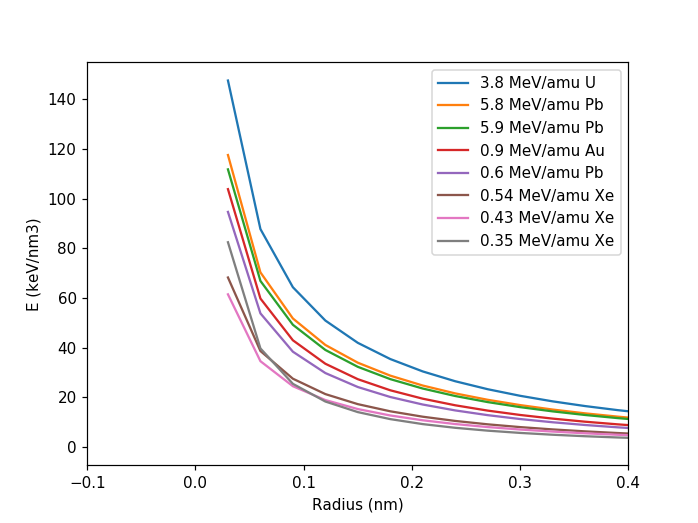

In [104]:
plt.figure()
for w in waligorski:
    plt.plot(w.t_r*1e9, w.W1D,'-', label=w.name)
    

plt.xlim(-0.1, 0.4)
# plt.ylim(1,)
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.xlabel('Radius (nm)')
plt.ylabel('E (keV/nm3)');

# 2D

In [105]:
%%time
size = (101, 101)
cell_size=0.3e-9 #0.3e-9#

print('Total Size: %.2f x %0.2f nm' %(size[0]*cell_size*1e9, size[1]*cell_size*1e9))
center_point = (int((size[0])/2), int((size[1])/2))


for w in waligorski:
    print(w.name)
    energy = convert_W2D(size, cell_size, w.W1D, n_subcells=11)
    #normal = el*cell_size*1e9/energy.sum()
    normal = cell_size*1e9 * integrate(w.t_r*1e9, w.W1D)/energy.sum()    
    w.W2D = energy*normal


Total Size: 30.30 x 30.30 nm
3.8 MeV/amu U
5.8 MeV/amu Pb
5.9 MeV/amu Pb
0.9 MeV/amu Au
0.6 MeV/amu Pb
0.54 MeV/amu Xe
0.43 MeV/amu Xe
0.35 MeV/amu Xe
CPU times: user 58.8 s, sys: 548 ms, total: 59.3 s
Wall time: 58.4 s


<IPython.core.display.Javascript object>


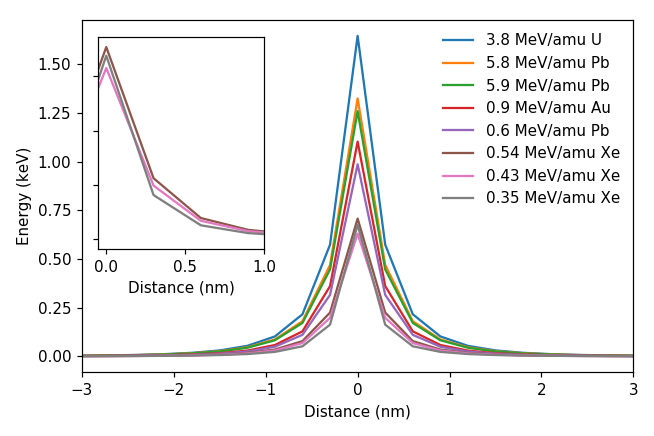

     Ion	Ion Energy (MeV)	Max (eV)	Final ee (keV/nm)	Total E (keV)
3.8 MeV/amu U : 	      904.5	      1.65	      55.15	      16.55
5.8 MeV/amu Pb : 	      1200.2	      1.32	      46.23	      13.87
5.9 MeV/amu Pb : 	      1162.1	      1.26	      44.00	      13.20
0.9 MeV/amu Au : 	      185.0	      1.10	      33.00	      9.90
0.6 MeV/amu Pb : 	      124.8	      0.99	      28.30	      8.49
0.54 MeV/amu Xe : 	      69.7	      0.71	      20.00	      6.00
0.43 MeV/amu Xe : 	      55.5	      0.63	      17.20	      5.16
0.35 MeV/amu Xe : 	      45.1	      0.68	      14.90	      4.47


In [113]:
fig, ax = plt.subplots(figsize=(6,4))
axins = ax.inset_axes([0.03, 0.35, 0.3,0.6])

for i,w in enumerate(waligorski):
    W2D = w.W2D
    xx = np.linspace(-(W2D.shape[0]-1)*cell_size*1e9/2, (W2D.shape[0]-1)*cell_size*1e9/2, W2D.shape[0])
    ax.plot(xx, W2D[:,center_point[0]] , '-', color=colors[i], label=w.name)
    if 'Xe' in w.name:
        W2D = w.W2D
        axins.plot(xx, W2D[:,center_point[0]] , '-', color=colors[i], label=w.name)
    
print('     Ion', 'Ion Energy (MeV)', 'Max (eV)', 'Final ee (keV/nm)', 'Total E (keV)', sep='\t')
for i,w in enumerate(waligorski):
    print(w.name + ' : ', '%0.1f'%(w.E*1e-3), '%0.2f'%w.W2D.max(), '%0.2f'%(w.W2D.sum()/(cell_size*1e9)),
          '%0.2f'%(w.eloss*cell_size*1e9), sep='\t      ')



# plt.xlim(-5*cell_size*1e9, 5*cell_size*1e9);
ax.set_xlim(-3,3)
axins.set_xlim(-0.05,1)
axins.set_yticklabels([])
ax.set_xlabel('Distance (nm)')
axins.set_xlabel('Distance (nm)')
ax.set_ylabel('Energy (keV)')

# plt.xscale('log')
# plt.yscale('log')
ax.legend(frameon=False);
fig.tight_layout();
# fig.savefig('/home/msequeira/Dropbox/Apps/Overleafaa/Thesis/images/Annex_Waligorski/deposition_curves.png')